# Distributed  code on cluster with DASK

### How it works?

Similar to the parallelization, the concept of the cluster is to execute multiple operations per time. Even thoguh these approaches are similar, in this case the instructions are executed in parallel over several CPUs that reside on the computers that compose the cluster instead of the single machine. 
The main idea, in fact, is to exploit the huge computation power of the cluster given by a larger number of CPUs and a larger amount of memory than a simple machine.

Dask is a powerful and simple instrument to create huge and scalable clusters and it allows to distribute the computation over the nodes that compose those clusters even with no strong knowledges on distributed calculos.

A cluster is mainly composed by three types of machines:
+ **Master machine**: master machine is the computer where the program is effectively running before to distrivuited the computation. In other terms, is the machine where you have to write your code and you have to work. Master machine communicato with Scheduler machine in order to submit the istructions to the cluster and in order to retrieve the results;
+ **Scheduler machine**: The scheduler machine is responsible of scheduling the instructions and to distribute their over the machines that compose the cluster. In other terms, it decide how to schedule the processes.
+ **Worker machine**: this type of machine is just an executor of instructions. A worker machine receive the instructions that it has to execute and then return the result to the scheduler.

To give you a better idea in how a cluster works, think to the computation graph that we have seen in the previous notebook. In this case, the master machine create the graph that is submitted to the Scheduler machine that assing the execution of each node to a Worker machine.
 


**Hint**
When you work on a cluster you have to keep in mind that *normal programming* method is not a good solution. This because you have no guarantees on when the program will be executed. 
In fact, each time you submit an instruction to the cluster, the task is put in a **queue**. This Queue contains the list of all tasks/instructions that have been submitted to the cluster. 
When a worker machine has finished an instructuion and is turned free again, a task is taken from the queue and executed on the machine. This process continues until the queue is empty. In other words, when you submit an instruction to the cluster you have to wait until the task will be executed and  the result available. 
Hence, it is trivial that this execution flow is not really suitable when you have a small instructions with no huge computation necessities, cause you need to wait results that can be potentially elaborated on your computer. In the other hand this is a powerfull method when you have to execute parallel instructions or with huge resources requests in terms of CPUs and RAM.

### Let's see an example

Let's take a slightly modified version of the first example of the previous notebook and try to dirtibuted it.

In [ ]:
from dask import delayed
import time

def increment(x):
    print("I'm icrementing "+str(x)+" on this cluster node!")
    time.sleep(5)
    return x + 1

def decrement(x):
    print("I'm decrementing "+str(x)+" on this cluster node!")
    time.sleep(3)
    return x - 1

def add(x, y):
    print("I'm summing "+str(x)+" and "+str(y)+" on this cluster node!")
    time.sleep(7)
    return x + y

The first step is to create the cluster. In this case the cluster is already up, but just to give you and idea, in order to create a cluster you have to type the following command.

+ dask-scheduler: this command must to be typed on your scheduler machine
+ dask-worker SCHEDULER_IP:SCHEDULER_PORT : this command must to be typed on each worker machine

a lot of option can be passed to each command, if like to try by yourself take a read to this link [Dask worker](http://distributed.dask.org/en/latest/worker.html).

The second step is to connect to the cluster, let's see how:

In [ ]:
from dask.distributed import Client

# Leeve blank to setup a local cluster. Put the scheduler IP to distributed cluster.

client = Client()
client.cluster

The last step is to run the instructions and then to retrieve the results:

In [ ]:
x = delayed(increment)(1)
y = delayed(decrement)(2)
total = delayed(add)(x, y)
total.compute()

Dask makes available a WebUI that allows to manage and monitor what is happening on the cluster. From this interface you can see the usage of the cluster nodes,  all the tasks that have to be processed and the general status of the cluster. The WebUI is available to the scheduler page: [Scheduler](http://test:port). 


### Other ways to distribute instructions to the cluster

Since Dask is a really flexible framework, it makes available other ways to distrubted tasks over a cluster.
One of those possibilities is to ```submit``` single instructions to the cluster.

Let's se how:

In [ ]:
future = client.submit(increment, 1)

client.gather(future)

The function ```increment``` with its agurment ```1``` is submitted to the cluster. The function ```submit``` returns the execution *promise* (the ```future``` variable) of the instruction that we had submit.

The ```future``` variable **not contains the real result**, but just the promise of its elaboration. To retrieve the result you have to invoke the ```gather``` function.


Sometimes you need to submit an instruction multiple time with different input parameters. This is a quite frequent scenario in in machine learning, for example when you want to optmize an algorithm for a particular dataset. The idea of this approach is to map the instruction that we want to executo to each argument.

Let's see an example on how do that:

In [ ]:
data = [0, 1, 2, 3, 4, 5, 6, 7, 8]

future_results = client.map(increment, data)
client.gather(future_results)

In contrast to the ```submit``` function, ```map``` function returns a list of *execution promises*. In other words it returns an exexution promises for each input.


### Retreive results from the cluster

As we have already view, when you work with a Cluster the results must be waited until the end of the computation of the submitted istructuions. 

The role of ```gather``` function is to wait until the results are available. In other words, when you invoke this method, the execution of the program wait until the execution promise is effectively satisfied and its result is available.


When you submit an instruction to the cluster, you can see the progress bar that show the progress of the sumitted job.

In [ ]:
from dask.distributed import wait, progress

future = client.submit(increment, 1)

progress(future)

client.gather(future)

When you have multiple instruction that have to be submitted to the cluster where are present some results depedencies, the ```gather``` function can be invoked at the end of the program. 
This means that you can submit to the cluster a task that takes as argument an execution promise of an instruction that has been previosly submitted. 

In other terms, ```gather``` function can be invoked only when the results have to effectively retrived from cluster in order to manipulate it.

Let's see an example:

In [ ]:
x = client.submit(increment, 1)
y = client.submit(decrement, 2)
total = client.submit(add, x, y)

print(total)     # This is still the execution promise
client.gather(total)  # This is the final result

**Hint**

This method is necessary to work in the right way with cluster, but some frameworks, as Apache Spark, that we're going to see in last lecture, they automatically retrieve the results without manually invoke this function.

### Exercise 1: Distribute a for-loop code with control flow

Let's go back to the exercise that we have seen previously. Try to parallelize the orginal code by distributing the instructions to the cluster.

In [ ]:
def double(x):
    time.sleep(4)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Sequential code

In [ ]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = increment(x)
    results.append(y)
    
total = sum(results)
print(total)

Complete the blank space by yourself

In [ ]:
%%time

results = []
for x in data:
    if is_even(x):  # even
        y = #put your code here
    else:          # odd
        y = #put your code here
    results.append(y)
    
result = #put your code here
total = client.gather(result)

### Exercise 2: Count how many words are present in a series of documents 

What you have to do is to count how many words are present in each document. Document are ~8200. This is classical example in data analisys.

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from dask.distributed import Client
import time

categories = [
     'comp.graphics',
     'comp.os.ms-windows.misc',
     'comp.sys.ibm.pc.hardware',
     'comp.sys.mac.hardware',
     'comp.windows.x',
     'misc.forsale',
     'rec.autos',
     'rec.motorcycles',
     'rec.sport.baseball',
     'rec.sport.hockey',
     'sci.crypt',
     'sci.electronics',
     'sci.med',
     'sci.space'
]

dataset = fetch_20newsgroups(subset='train', categories=categories ).data

In [ ]:
print("Texts document present on the dataset: "+str(len(dataset)))

In [ ]:
client = Client()


In [ ]:
def count_word_in_statement(text):
    """
    This function takes a text as input and return the number of the words that it contains
    """
    splitted_words = text.split()
    return len(text)

In [ ]:
%time

futures = #put your code here
results = client.gather(futures)
for index in range(0, len(results)):
    print("Text #"+str(index+1)+" contains "+str(results[index])+" words")
    
    

### Exercise 3: Calculate the first *n* Fibonacci numbers

The code below is the ```sequential``` version of  the code. 

In [ ]:
from dask import delayed

def append(arr = [], val = 0):
    if val != None:
        arr.append(val)
    return arr

def fibonacci_sequential(num):
    i = 1
    if num == 0:
        fibonacci = []
    elif num == 1:
        fibonacci = []
        fibonacci.append(1)
    elif num == 2:
        fibonacci = []
        fibonacci.append(1)
        fibonacci.append(1)
    elif num > 2:
        fibonacci = []
        fibonacci.append(1)
        fibonacci.append(1)
        while i < (num - 1):
            fibonacci.append(fibonacci[i] + fibonacci[i-1])
            i += 1
    return fibonacci

result = fibonacci_sequential(5)
print("The first n fibonacci numbers are: " + str(result))

Below you can find the partial distributed code. Complete the blank spaces by yourself.

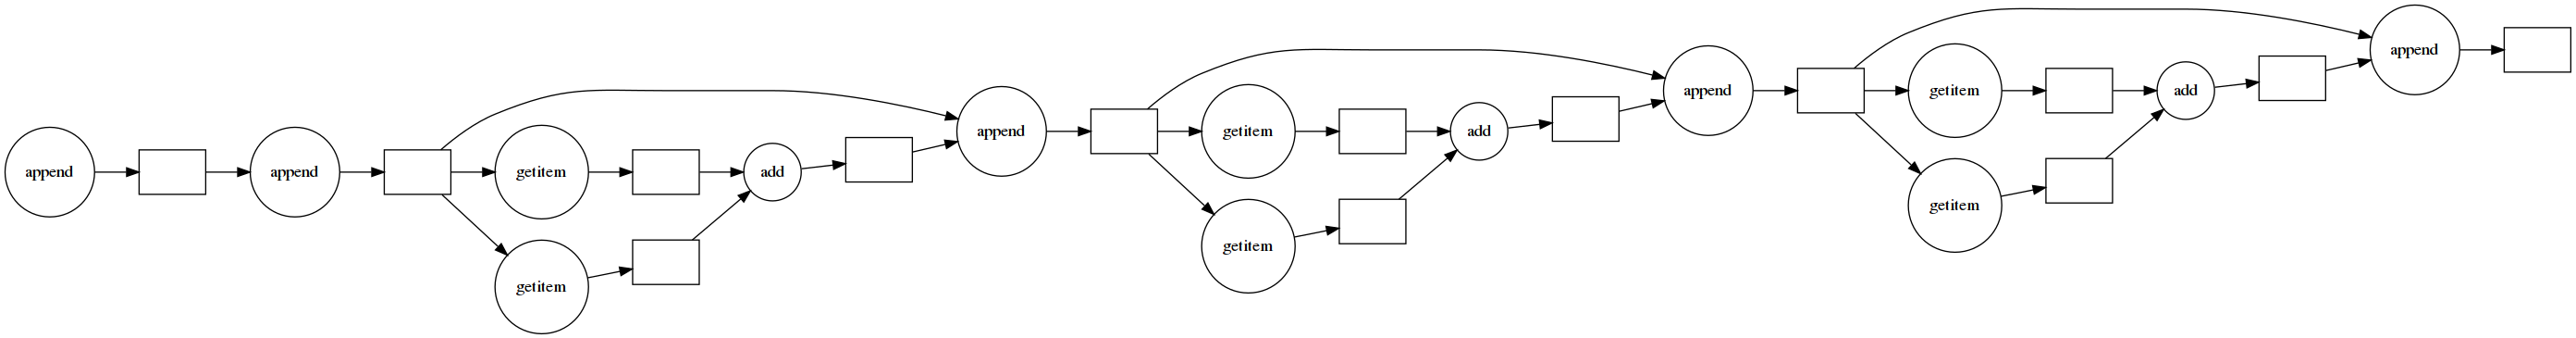

[1, 1, 2, 3, 5]


In [1]:
from dask import delayed

def append(arr = [], val = 0):
    #time.sleep(3)
    if val != None:
        arr.append(val)
    return arr

def fibonacci(num):
    i = 1
    if num == 0:
        future = delayed(append)([], None)
    elif num == 1:
        future = delayed(append)([], 1)
    elif num == 2:
        future_0 = delayed(append)([], 1)
        future = delayed(append)(future_0, 1)
    elif num > 2:
        future_0 = delayed(append)([], 1)
        future = delayed(append)(future_0, 1)
        while i < (num - 1):
            future = delayed(append)(future, future[i] + future[i-1])
            #fib.append(fib[i] + fib[i-1])
            i += 1
    return future

#print(fibonacci(3).compute(scheduler='single-threaded', rerun_exceptions_locally=True, ))
future = fibonacci(5)
display(future.visualize(rankdir="LR"))
print(future.compute())

### Exercise 4: Count how many values are between 0 and 10 there are in each row of a random matrix

In [ ]:
import numpy as np

## creation of a matrix of 100 rows and 10 columns with each value between 0 and 100.
np.random.RandomState(42)
arr = np.random.randint(0, 100, size=[100, 10])

In [ ]:
def howmany_within_range(row):
    """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
    count = 0
    for n in row:
        if 0 <= n <= 10:
            count = count + 1
    return count


futures = client.map(howmany_within_range, arr)
resutls = client.gather(futures)
print(results)

### Exercise 5: Estimating π using Monte Carlo integration

In mathematics, Monte Carlo integration is a technique for numerical integration using random numbers. It is a particular Monte Carlo method that numerically computes a definite integral ( [Wiki](https://en.wikipedia.org/wiki/Monte_Carlo_integration) ).

In mathematics it is possibile to estimate a value of Pi using the this method. The idea is to generate a large number of random points and see how many fall in the circle enclosed by the unit square.

The below code is a ```sequential``` version of Pi estimation with Monte Carlo integration.

In [ ]:
import numpy as np
import random
import math

**Hints** value of ```inside_or_out_side``` is 1 if the point is *inside the circle* 0 otherwise.

In [ ]:

n = 10000

def pi_python_sequential(n):
    points = []
    for i in range(0, n):
        inside_or_out_side = 0
        x2 = random.random()**2
        y2 = random.random()**2
        if math.sqrt(x2 + y2) < 1.0:
            inside_or_out_side = 1
        
        points.append(inside_or_out_side)
    
    return np.multiply(np.divide(float(sum(points)), n), 4)

pi = pi_python_sequential(n)
print("Estimation of Pi: "+str(pi))

Wath you have to do in this exercise is to revirete the original code in order to distribute the computation over the cluster nodes.
Let's start:

In [ ]:
from dask.distributed import Client
from dask import delayed

In [ ]:
# Leeve blank to setup a local cluster. Put the scheduler IP to distributed cluster.
client = Client()
client.cluster

In [ ]:
%time

n = 100000
def partial_monte_carlo():
    inside_out_side = 0 
    
    x2 = random.random()**2
    y2 = random.random()**2
    if math.sqrt(x2 + y2) < 1.0:
        inside_out_side = 1
    return inside_out_side

def pi_python(n):
    points=[]
    
    for i in range(n):
        points.append(delayed(partial_monte_carlo)())
    
    result = delayed(np.multiply)(delayed(np.divide)(delayed(float)(delayed(sum)(points)), n), 4)
    
    return result

estimation = pi_python(n);
print("Estimation of Pi: "+str(estimation.compute()))

Try to change the value of n (number of the generated points) and see how the the loading of the cluster of the page change